<p align="center"><img src="https://iot-polje.fer.hr/images/50037294/IoT_polje_logo_hr_horizontalni2.jpg"></p>

<p align="center"><h1>Nitro: Python code for deep learning classification of nitrogen defficiency from maize images</h1></p align="center">


| Description | URL |
| --- | --- |
| Repo | https://github.com/vlattko/nitro |
| Web | https://iot-polje.fer.hr/iot-polje/en |
| Funding | European Union (KK.01.1.1.04.0108) |

For CPU training, restart kernel, uncomment and run the below cell.

In [3]:
'''import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1 # disable GPU'''

In [ ]:
from utils import download_unzip

url = 'https://data.mendeley.com/public-files/datasets/g7xnn2bm4g/files/0caeb722-2a0e-4690-9f23-84f3230f2218/file_downloaded'
path = os.getcwd()

download_unzip(url, path)

In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io
import skimage.color as color
import random as r
import math
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.layers import Input, UpSampling2D,BatchNormalization
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as keras
import argparse
import sys
#import cv2
import skimage.transform as trans
from PIL import Image
import numpy as np
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dense
from tensorflow.keras.layers import AvgPool2D, GlobalAveragePooling2D, MaxPool2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import ReLU, concatenate
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.losses import binary_crossentropy


In [103]:
# Change to 300 for publication ready figures
plt.rcParams['figure.dpi'] = 300

In [7]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
s=(200,200)

In [6]:
# join current directory with Images folder
dir=os.path.join(os.getcwd(), 'Images')
image_directory = os.path.join(dir, 'resized')

In [33]:
def resize_images(directory, size=(300, 300), ratio=False, metadata=False, extensions=('.jpg', '.png', '.JPG', '.PNG')):
    """
    Resize all images in a directory to a given size.
    :param directory: Path to the directory containing the images.
    :param size: The new size of the images.
    :param ratio: Whether to keep the aspect ratio.
    :param metadata: Whether to keep the metadata.
    :param extensions: The extensions of the files to resize.
    """
    new_directory = os.path.join(directory, 'resized')
    if not os.path.exists(new_directory):
        os.makedirs(new_directory)
    for filename in os.listdir(directory):
        if filename.endswith(extensions):
            image = Image.open(os.path.join(directory, filename))
            if not metadata:
                # Remove metadata
                data = list(image.getdata())
                image = Image.new(image.mode, image.size)
                image.putdata(data)
            if ratio:
                width, height = image.size
                new_height = int(height * size[0] / width)
                image = image.resize((size[0], new_height))
            else:
                image = image.resize(size)
            image.save(os.path.join(new_directory, filename))

In [34]:
resize_images(directory=dir, size=s, extensions=(".JPG"), ratio=False)

In [7]:
np.random.seed(12340)

In [27]:
def load_images(directory, batch_size=16, suffix='', use_indices=False, use_segmentation=False):
    """load images from a directory
    Args:
        directory (_type_): _description_
        batch_size (int, optional): _description_. Defaults to 16.
        suffix (str, optional): _description_. Defaults to ''.
        use_indices (bool, optional): _description_. Defaults to False.
        use_segmentation (bool, optional): _description_. Defaults to False.

    Yields:
        _type_: _description_
    """   
    images = []
    labels = []
    masks = []  # List to store the segmentation masks
    filenames = iter(os.listdir(directory))
    for i, filename in enumerate(filenames):
        if filename.endswith(('.jpg', '.png', '.JPG', '.PNG')):
            image = tf.io.read_file(os.path.join(directory, filename))
            image = tf.image.decode_image(image, channels=3)
            image = tf.image.resize(image, s)
            image = tf.image.convert_image_dtype(image, tf.float32)

            # Calculate normalized indices
            if use_indices:
                r, g, b = tf.split(image, num_or_size_splits=3, axis=-1)
                rg = (r - g) / (r + g)
                rb = (r - b) / (r + b)
                gb = (g - b) / (g + b)
                image = tf.concat([rg, rb, gb], axis=-1)

            # Perform K-means segmentation and extract masks
            if use_segmentation:
                reshaped_image = tf.reshape(image, [-1, 3])
                kmeans = KMeans(n_clusters=2)  # Change the number of clusters here
                kmeans.fit(reshaped_image.numpy())
                clustered = kmeans.cluster_centers_[kmeans.labels_]
                mask = tf.reshape(clustered, image.shape)
                masks.append(mask)

            images.append(image)
            
            label = filename.split(' ')[0] + suffix
            labels.append(label)
        
        if (i + 1) % batch_size == 0 or (i + 1) == len(os.listdir(directory)):
            images = tf.stack(images)
            labels = tf.stack(labels)
            masks = tf.stack(masks)  # Stack the segmentation masks into a single tensor
            
            yield images, labels, masks  # Yield the images, labels, and masks
            images = []
            labels = []
            masks = []  # Reset the list of segmentation masks

Data loader accepts additional argument to calculate normalized indices (`use_indices`) instead RGB channels. This might be worthwhile for enhancing plant features.

In [ ]:
# if k-means segmentation is used, use this function to encode the labels
def encode_labels(labels):
    # docstring here
    """ encode labels
    Args:
        labels (_type_): _description_
        """
    unique_labels, _ = tf.unique(labels)
    label_to_index = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(unique_labels, tf.range(tf.size(unique_labels))),
        -1
    )
    encoded_labels = label_to_index.lookup(labels)
    return encoded_labels.numpy()

In [28]:
all_images = []
all_labels = []
all_masks = []  # List to store the segmentation masks
for images, labels, masks in load_images(image_directory, batch_size=16, use_segmentation=True):  # Update this line to receive masks
    if images.shape[0] > 0: # Check if the batch is not empty
        all_images.append(images)
        all_labels.append(labels)
        all_masks.append(masks)  # Append the masks to all_masks

all_images = tf.concat(all_images, axis=0)
all_labels = tf.concat(all_labels, axis=0)
all_masks = tf.concat(all_masks, axis=0)  # Concatenate all masks into a single tensor

# Encode the labels
all_labels = encode_labels(all_labels)

# Reshape the images to 2D
all_images = tf.reshape(all_images, (all_images.shape[0], -1))
all_masks = tf.reshape(all_masks, (all_masks.shape[0], -1))


In [45]:
# balance the classes using oversampling
ros = RandomOverSampler()
balanced_images, balanced_labels = ros.fit_resample(all_images.numpy(), all_labels)
balanced_masks, _ = ros.fit_resample(all_masks.numpy(), all_labels)  # _ for ignoring the labels

# convert the labels to integer type
balanced_labels = balanced_labels.astype(int)

# convert the data to TensorFlow tensors
balanced_images = tf.convert_to_tensor(balanced_images)
balanced_labels = tf.convert_to_tensor(balanced_labels)
balanced_masks = tf.convert_to_tensor(balanced_masks)  # Convert the masks back to TensorFlow tensors

print(balanced_images.shape)
print(balanced_labels.shape)


(1200, 120000)
(1200,)


In [47]:
# Reshape the images and masks back to 4D
balanced_images = tf.reshape(balanced_images, (-1, s[0], s[1], 3))
balanced_masks = tf.reshape(balanced_masks, (-1, s[0], s[1], 1))  # Reshape the masks

print(balanced_images.shape[0])
print(balanced_labels.shape[0])

1200
1200


Split to training and test sets is carried out balancing the classes, random - sampling 20% of the full dataset.

In [53]:
# Split the data into training and test sets
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_indices, test_indices = next(sss.split(balanced_images.numpy(), balanced_labels))

train_images = tf.gather(balanced_images, train_indices)
test_images = tf.gather(balanced_images, test_indices)
train_labels = tf.gather(balanced_labels, train_indices)
test_labels = tf.gather(balanced_labels, test_indices)

# Split the masks into training and test sets
train_masks = tf.gather(all_masks, train_indices)
test_masks = tf.gather(all_masks, test_indices)

# Convert the data back to TensorFlow tensors
train_images = tf.convert_to_tensor(train_images)
test_images = tf.convert_to_tensor(test_images)
train_labels = tf.convert_to_tensor(train_labels)
test_labels = tf.convert_to_tensor(test_labels)

# Convert the masks back to TensorFlow tensors
train_masks = tf.convert_to_tensor(train_masks)
test_masks = tf.convert_to_tensor(test_masks)

# Masks

In this example, K-means masks are segmenting background from plants. Due to presence of randomness in K-means mask generation, masks should be inspected prior to use, and possibly inverted. Masks are useful for U-Net model which is not yet implemented (end of notebook).

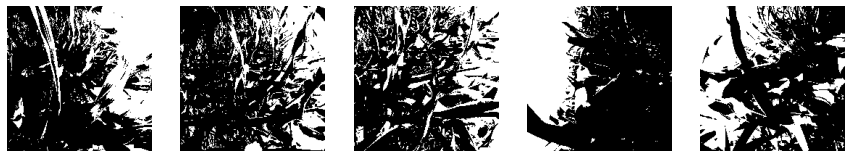

In [54]:
# Reshape the masks back to original shape
train_masks_plot = tf.reshape(train_masks, (-1, s[0], s[1], 3))

# Select 5 random indices from train_masks
random_indices = np.random.choice(train_masks_plot.shape[0], size=5, replace=False)

# Plot the masks
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, idx in enumerate(random_indices):
    # Display the first channel of the mask
    axes[i].imshow(train_masks_plot[idx, :, :, 0], cmap='gray')
    axes[i].axis('off')
plt.show()


In [ ]:
# Uncomment to invert the masks

'''# Convert the float masks to binary masks
train_masks_binary = np.where(train_masks > 0, 1, 0)
test_masks_binary = np.where(test_masks > 0, 1, 0)

# Invert the binary masks
train_masks_inverted = np.logical_not(train_masks_binary)
test_masks_inverted = np.logical_not(test_masks_binary)

# Convert the boolean masks to integer masks
train_masks_inverted = train_masks_inverted.astype(np.uint8)
test_masks_inverted = test_masks_inverted.astype(np.uint8)'''



For saving the loaded and encoded dataset as a Tensorflow dataset, run next two cells.

In [ ]:
# Convert list of images, labels, and masks to a TensorFlow dataset
dataset = tf.data.Dataset.from_tensor_slices((all_images, all_labels, all_masks))

# Define the function to encode the images, labels, and masks into tf.Example messages
def encode_tfexample(image, label, mask):
    image_feature = tf.train.Feature(float_list=tf.train.FloatList(value=image.flatten()))
    label_feature = tf.train.Feature(int64_list=tf.train.Int64List(value=[label]))
    mask_feature = tf.train.Feature(float_list=tf.train.FloatList(value=mask.flatten()))
    feature = {'image': image_feature, 'label': label_feature, 'mask': mask_feature}
    return tf.train.Example(features=tf.train.Features(feature=feature))

# Map the encoding function to the dataset
dataset = dataset.map(lambda x, y, z: encode_tfexample(x, y, z).SerializeToString())

# Save the dataset to a TFRecord file
writer = tf.data.experimental.TFRecordDataset('dataset.tfrecord')
writer.write(dataset)


In [23]:
# load saved dataset:

# Define the feature structure for the images, labels, and masks
feature_structure = {
    'image': tf.io.FixedLenFeature([s[0]*s[1]*3], tf.float32),  # Adjust the shape as needed
    'label': tf.io.FixedLenFeature([], tf.int64),
    'mask': tf.io.FixedLenFeature([s[0]*s[1]*3], tf.float32)  # Adjust the shape as needed
}

# Define the function to parse the tf.Example messages
def parse_tfexample(example_proto):
    return tf.io.parse_single_example(example_proto, feature_structure)

# Load the dataset from the TFRecord file
dataset = tf.data.TFRecordDataset('dataset.tfrecord')

# Parse the tf.Example messages
dataset = dataset.map(parse_tfexample)

# Now dataset is a tf.data.Dataset of (image, label, mask) tuples

In [52]:
unique_train_labels, _ = tf.unique(train_labels)
num_train_labels = tf.size(unique_train_labels).numpy()
print("Number of unique labels in train set:", num_train_labels)

unique_test_labels, _ = tf.unique(test_labels)
num_test_labels = tf.size(unique_test_labels).numpy()
print("Number of unique labels in test set:", num_test_labels)

Number of unique labels in train set: 3
Number of unique labels in test set: 3


# Image augmentation

To increase the number of images for model training, ImageDataGenerator method is used. Parameters for augmentation procedure are to experiment with. In this instance, rotation is set to 20°, shift, shear and zoom ranges to 0.2, images will be flipped horizontally and the fill mode is set to nearest.

In [57]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

Object instantiated below as `model` represents [DenseNet 121](https://doi.org/10.1109/CVPR.2017.243), shown to be able to [capture plant leaf features](https://doi.org/10.1007/s00521-021-06714-z).

In [104]:
def densenet(input_shape, n_classes, filters = 32):
    # docstring
    """ densenet
    Args:
        input_shape (_type_): _description_
        n_classes (_type_): _description_
        filters (int, optional): _description_. Defaults to 32.
    """    
    #batch norm + relu + conv
    def bn_rl_conv(x,filters,kernel=1,strides=1):
        
        x = BatchNormalization()(x)
        x = ReLU()(x)
        x = Conv2D(filters, kernel, strides=strides,padding = 'same')(x)
        return x
    
    def dense_block(x, repetition):
        
        for _ in range(repetition):
            y = bn_rl_conv(x, 4*filters)
            y = bn_rl_conv(y, filters, 3)
            x = concatenate([y,x])
        return x
        
    def transition_layer(x):
        
        x = bn_rl_conv(x, K.int_shape(x)[-1] //2 )
        x = AvgPool2D(2, strides = 2, padding = 'same')(x)
        return x
    
    input = Input (input_shape)
    x = Conv2D(64, 7, strides = 2, padding = 'same')(input)
    x = MaxPool2D(3, strides = 2, padding = 'same')(x)
    
    for repetition in [6,12,24,16]:
        
        d = dense_block(x, repetition)
        x = transition_layer(d)
    x = GlobalAveragePooling2D()(d)
    output = Dense(n_classes, activation = 'softmax')(x)
    
    model = Model(input, output)
    return model
input_shape = s[0], s[1], 3
n_classes = 3
model = densenet(input_shape,n_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_114 (Conv2D)            (None, 100, 100, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_76 (MaxPooling2D  (None, 50, 50, 64)  0           ['conv2d_114[0][0]']             
 )                                                                                            

In [49]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
batch_size = 32
epochs = 100
history_dn = model.fit(
    datagen.flow(train_images, train_labels, batch_size=batch_size),
    epochs=epochs,
    steps_per_epoch=len(train_images) // batch_size,
    validation_data=(test_images, test_labels)
)

Epoch 1/100
30/30 [==============================] - 205s 6s/step - loss: 2.4449 - accuracy: 0.3552 - val_loss: 101523.7500 - val_accuracy: 0.3333
Epoch 2/100
30/30 [==============================] - 185s 6s/step - loss: 1.2986 - accuracy: 0.4198 - val_loss: 4718.3354 - val_accuracy: 0.3333
Epoch 3/100
30/30 [==============================] - 187s 6s/step - loss: 1.1636 - accuracy: 0.4458 - val_loss: 1.8877 - val_accuracy: 0.3583
Epoch 4/100
30/30 [==============================] - 186s 6s/step - loss: 1.1050 - accuracy: 0.4833 - val_loss: 1.9888 - val_accuracy: 0.3333
Epoch 5/100
30/30 [==============================] - 189s 6s/step - loss: 1.0103 - accuracy: 0.5063 - val_loss: 3.6167 - val_accuracy: 0.3333
Epoch 6/100
30/30 [==============================] - 193s 6s/step - loss: 1.0199 - accuracy: 0.5063 - val_loss: 13.4042 - val_accuracy: 0.3375
Epoch 7/100
30/30 [==============================] - 192s 6s/step - loss: 0.9778 - accuracy: 0.4906 - val_loss: 39.1267 - val_accuracy: 0.2

In [51]:
# test model
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print('\nTest accuracy:', test_acc)
# test recell, f1 and precision
y_pred = model.predict(test_images)
y_pred = np.argmax(y_pred, axis=1)
y_true = test_labels
print("Recall: ", recall_score(y_true, y_pred, average="macro"))
print("Precision: ", precision_score(y_true, y_pred, average="macro"))
print("F1: ", f1_score(y_true, y_pred, average="macro"))


8/8 - 11s - loss: 1.2263 - accuracy: 0.5583 - 11s/epoch - 1s/step

Test accuracy: 0.5583333373069763
8/8 [==============================] - 13s 1s/step
Recall:  0.5583333333333333
Precision:  0.5957921864171865
F1:  0.5679556745769059


In [86]:
# some custom architecture

def create_model(learning_rate=None):
    # docstring
    """ create_model
    Args:
        learning_rate (_type_, optional): _description_. Defaults to None.
    """     
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(s[0], s[1], 3)), # Tu promijeni size
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'), # Tu promijeni size
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        tf.keras.layers.Conv2D(16, (3, 3), activation='relu'), # Tu promijeni size
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(3, activation='softmax')
    ])
    if learning_rate is None:
            model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    else:
        learning_rate = learning_rate
        optimizer = Adam(learning_rate=learning_rate)
        model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    
    return model

model2 = create_model(learning_rate=0.00005)



In [106]:
# model architecture
model2.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_106 (Conv2D)         (None, 198, 198, 64)      1792      
                                                                 
 max_pooling2d_72 (MaxPoolin  (None, 99, 99, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_107 (Conv2D)         (None, 97, 97, 32)        18464     
                                                                 
 max_pooling2d_73 (MaxPoolin  (None, 48, 48, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_108 (Conv2D)         (None, 46, 46, 16)        4624      
                                                                 
 max_pooling2d_74 (MaxPoolin  (None, 23, 23, 16)     

In [88]:
batch_size = 64
history2 = model2.fit(
    datagen.flow(train_images, train_labels, batch_size=batch_size),
    epochs=1000,
    steps_per_epoch=len(train_images) // batch_size,
    validation_data=(test_images, test_labels)
)

Epoch 1/1000
15/15 [==============================] - 26s 2s/step - loss: 1.0981 - accuracy: 0.3313 - val_loss: 1.0937 - val_accuracy: 0.3458
Epoch 2/1000
15/15 [==============================] - 27s 2s/step - loss: 1.0929 - accuracy: 0.3490 - val_loss: 1.0920 - val_accuracy: 0.3292
Epoch 3/1000
15/15 [==============================] - 25s 2s/step - loss: 1.1008 - accuracy: 0.3260 - val_loss: 1.0924 - val_accuracy: 0.3333
Epoch 4/1000
15/15 [==============================] - 25s 2s/step - loss: 1.0950 - accuracy: 0.3323 - val_loss: 1.0891 - val_accuracy: 0.3375
Epoch 5/1000
15/15 [==============================] - 26s 2s/step - loss: 1.0952 - accuracy: 0.3458 - val_loss: 1.0869 - val_accuracy: 0.3500
Epoch 6/1000
15/15 [==============================] - 26s 2s/step - loss: 1.0847 - accuracy: 0.3823 - val_loss: 1.0861 - val_accuracy: 0.3458
Epoch 7/1000
15/15 [==============================] - 26s 2s/step - loss: 1.0921 - accuracy: 0.3750 - val_loss: 1.0842 - val_accuracy: 0.4042
Epoch 

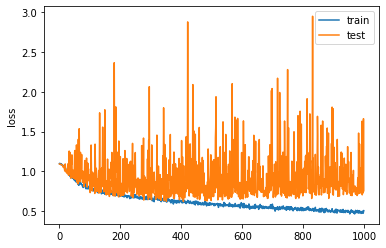

In [89]:
# plot history
plt.plot(history2.history['loss'], label='train')
plt.plot(history2.history['val_loss'], label='test')
plt.ylabel('loss')
plt.legend()
plt.show()


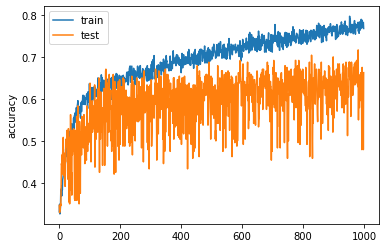

In [90]:
# plot history
plt.plot(history2.history['accuracy'], label='train')
plt.plot(history2.history['val_accuracy'], label='test')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [99]:
# test model
test_loss, test_acc = model2.evaluate(test_images, test_labels, verbose=2)
print('\nTest accuracy:', test_acc)
# test recell, f1 and precision
y_pred = model2.predict(test_images)
y_pred = np.argmax(y_pred, axis=1)
y_true = test_labels
print("Recall: ", recall_score(y_true, y_pred, average="macro"))
print("Precision: ", precision_score(y_true, y_pred, average="macro"))
print("F1: ", f1_score(y_true, y_pred, average="macro"))

8/8 - 1s - loss: 0.7568 - accuracy: 0.6625 - 1s/epoch - 156ms/step

Test accuracy: 0.6625000238418579
8/8 [==============================] - 1s 153ms/step
Recall:  0.6625
Precision:  0.6695772946859903
F1:  0.6624446456336476


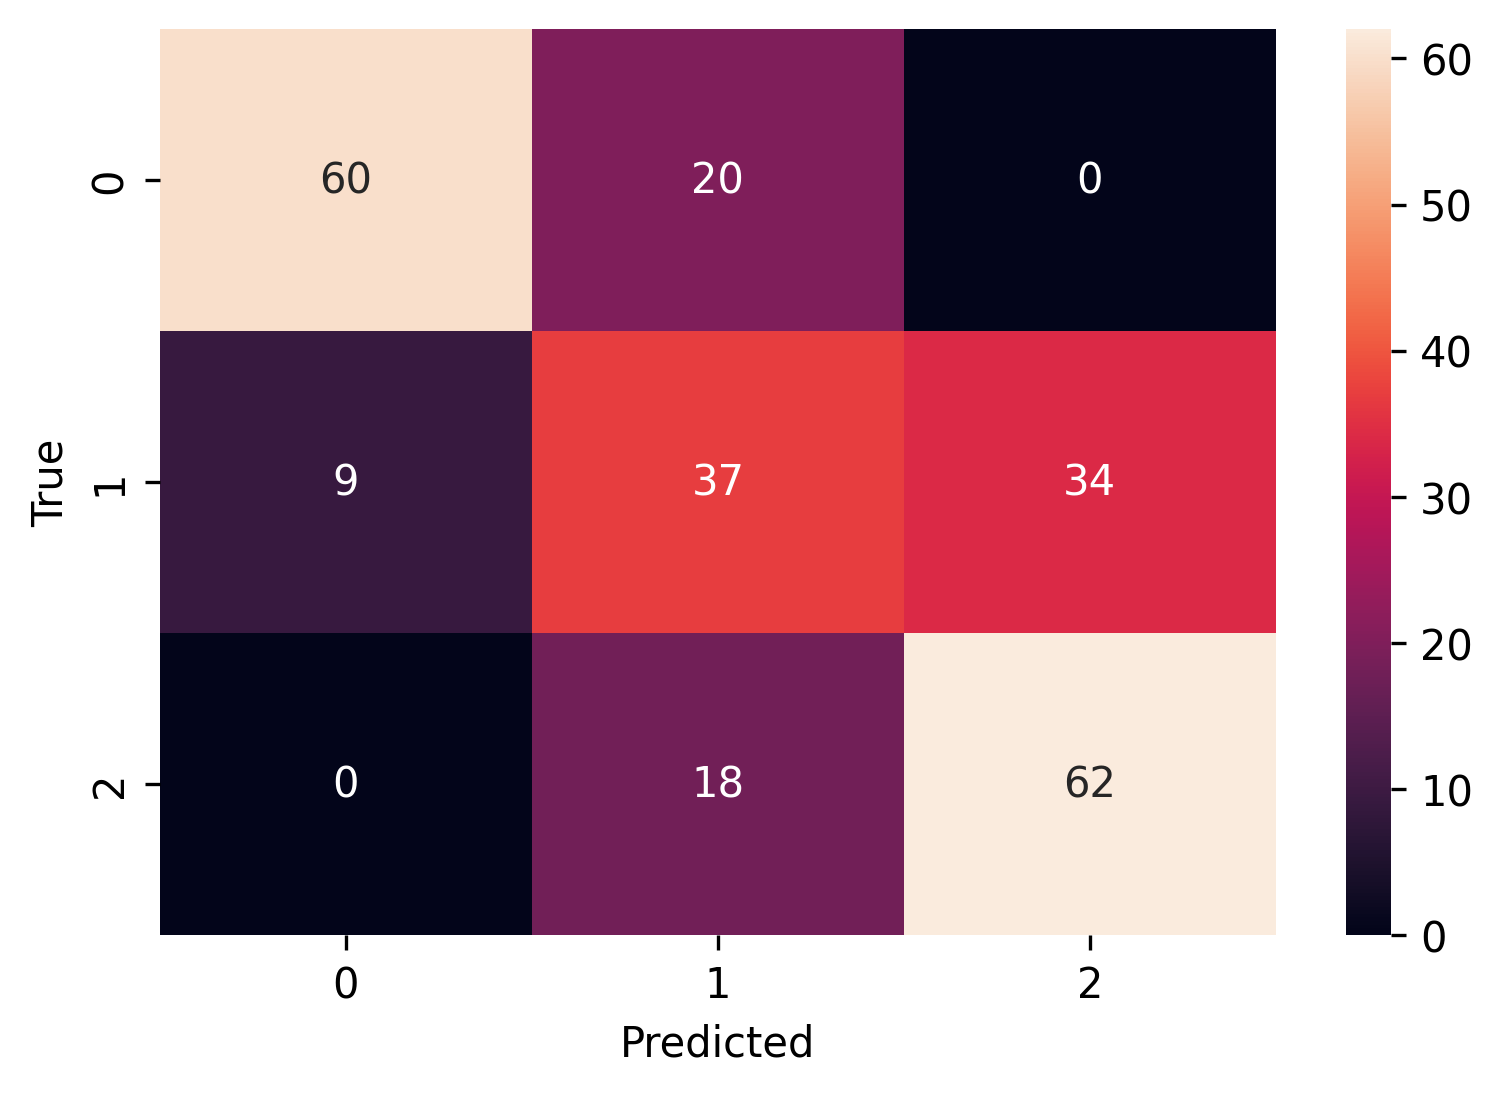

In [102]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.show()


In [ ]:
# not yet finished
def unet(input_size = (512,512,1)):
    pass
'''    """ unet
    Args:
        input_size (_type_, optional): _description_. Defaults to (512,512,1).
    """    
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2DTranspose(512,2,strides=(2,2),padding='same')(drop5)
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2DTranspose(256,2,strides=(2,2),padding='same')(conv6)
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2DTranspose(128,2,strides=(2,2),padding='same')(conv7)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2DTranspose(64,2,strides=(2,2),padding='same')(conv8)
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)

    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs, conv10)

    model.compile(optimizer = Adam(learning_rate = 1e-4), loss='binary_crossentropy', metrics=[dice_coef])

    model.summary()
    return model
smooth = 1

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1.-dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_coef_loss(y_true, y_pred)
filepath="cnn-parameters-improvement-{epoch:02d}-{dice_coef:.2f}"
# save the model with the best validation (development) accuracy till now
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor=[dice_coef], verbose=1, save_best_only=True, mode='max'))

model=unet()'''